In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from tkinter.filedialog import askdirectory

#Defining the JM colours
JM_colours = {'dark blue':(30/235,34/235,170/235), 'cyan':(0,172/235,233/235), 'teal':(157/235,211/235,203/235), 'pink':(229/235,0,118/235), 'grey':(87/235,87/235,86/235), 'light grey':(227/235,227/235,227/235), 'purple':(110/235,54/235,140/235), 'magenta':(229/235,0/235,118/235)}

## Import the folder with .mpt files from EC Lab
User interactive:
1. Select the data folder which contains .mpt files with "CV" in the file name
2. Enter the electrode area (cm2)

In [3]:
# Open a Tkinter window to select the .mpt file interactively
Tk().withdraw()
file_path = askopenfilename(title='Select .mpt File')

# Get user input for electrode area in cm²
electrode_area_cm2 = float(input("Enter the electrode area (cm²): "))

data_list = []

# Read the .mpt file
with open(file_path, 'r', encoding='iso-8859-1') as f:
    lines = f.readlines()

    # Extract the column names from the header line
    header_line = lines[68].strip().split('\t')

    # Extract the data section
    data_start = 69
    data_lines = [line.strip().split('\t') for line in lines[data_start:]]

    # Create a dataframe for the data
    df_data = pd.DataFrame(data_lines, columns=header_line)

    # Create a dictionary or list of values for the file
    data = {
        'File': file_path,
        'Data': df_data
    }

    data_list.append(data)

df = pd.DataFrame(data_list)
df.head()


,File,Data
0,C:/Users/GadolS01/OneDrive - Johnson Matthey/C...,mode ox/red error control changes counte...


## Extract the relevant columns and clean the dataset

The following code merges all the data contained in the folder and creates a dataframe "result_df".

In [4]:
# Create an empty dataframe to store the extracted values
result_df = pd.DataFrame(columns=['File', 'Ewe/V', '<I>/mA'])

# Iterate over each dataframe in df
for i, row in df.iterrows():
    file_data = row['Data']
    file_name = row['File']

    # Accessing specific columns from each dataframe
    ewe_values = file_data['Ewe/V']
    current_values = file_data['<I>/mA']
    cycle_number = file_data['cycle number']

    # Create a temporary dataframe with the extracted values
    temp_df = pd.DataFrame({
        'File': [file_name] * len(ewe_values),
        'Ewe/V': ewe_values,
        '<I>/mA': current_values,
        'Cycle number': cycle_number
    })

    # Append the temporary dataframe to the result dataframe
    result_df = pd.concat([result_df, temp_df], ignore_index=True)

result_df['<I>/mA'] = result_df['<I>/mA'].astype(float) / electrode_area_cm2
result_df = result_df.rename(columns={'<I>/mA': '<I>/mAcm-2'})
result_df['Ewe/V'] = result_df['Ewe/V'].astype(float).round(2)

# Convert the cycle number column to float
result_df['Cycle number'] = result_df['Cycle number'].astype(float)

# Get the unique cycle numbers in the dataframe
unique_cycles = result_df['Cycle number'].unique()

# Define a dictionary to map the unique cycle numbers to the desired values
cycle_mapping = {cycle: i+1 for i, cycle in enumerate(unique_cycles)}

#Replace the cycle numbers in the 'Cycle number' column
result_df['Cycle number'] = result_df['Cycle number'].replace(cycle_mapping)

#Print the updated dataframe
result_df.head()

,File,Ewe/V,<I>/mAcm-2,Cycle number
0,C:/Users/GadolS01/OneDrive - Johnson Matthey/C...,-0.09,-182.154847,1.0
1,C:/Users/GadolS01/OneDrive - Johnson Matthey/C...,-0.09,-180.867405,1.0
2,C:/Users/GadolS01/OneDrive - Johnson Matthey/C...,-0.09,-178.468507,1.0
3,C:/Users/GadolS01/OneDrive - Johnson Matthey/C...,-0.09,-176.074352,1.0
4,C:/Users/GadolS01/OneDrive - Johnson Matthey/C...,-0.09,-173.689677,1.0


The following code print a dataframe which contain the filenames of the folder and their index in the dictionary (it will be useful later).

## Dataset evaluation and Graph builder

The following function can be modified according to the user's needs (ask Sebastiano).

In [5]:
#Define variables to store the minimum and maximum 'Ewe' values
min_ewe = None
max_ewe = None

def apply_filters(df):
    """
    Applies filters to the given DataFrame based on user input.
    It contains two masks: 
    1. Selection of the cycle number: most CVs are run for more than
        one cycle, here the second one is selected.
    2. Selection of the potential range: CVs can be measured in different
        potential ranges, here the user can specify the min and max value
        of the range they would like to analyse
    
    Parameters:
        df (pandas.DataFrame): The DataFrame to filter
    
    Returns:
        pandas.DataFrame: The filtered DataFrame
    """
    global min_ewe, max_ewe  # Declare the variables as global to modify them
    
    #Get the last cycle number
    #last_cycle_number = df['Cycle number'].max()
    
    #Prompt the user to input the range for 'Ewe' values
    if min_ewe is None:
        min_ewe = float(input("Enter the minimum 'Ewe' value: "))
    if max_ewe is None:
        max_ewe = float(input("Enter the maximum 'Ewe' value: "))

    #Set the mask for 'Ewe' values within the specified range
    mask = (df['Ewe/V'] >= min_ewe) & (df['Ewe/V'] <= max_ewe)
    
    #Apply the masks to filter the rows
    filtered_df = df[mask]

    return filtered_df

Here is an interactive graph builder, the user has to specify which data would like to plot (ref. dictionary_df to check the index of the dataframes dictionary). User inputs:
1. Index of results_df DataFrames dictionary
2. Minimum value for E<sub>we</sub> (Potential [V vs. RHE])
3. Maximum value for E<sub>we</sub> (Potential [V vs. RHE])
4. y/n selection for custom legend lables
5. Type the new label for customised legend
6. Repeat steps 1, 4 and 5 for all the data or enter 'exit' to show the plot

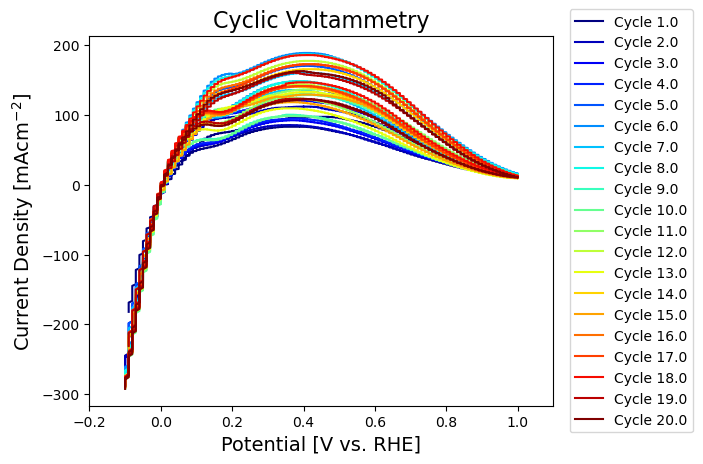

In [7]:
# Create an empty dictionary to store the dataframes
dataframes = {}

# Create an empty dictionary to store the legend handles
legend_handles = {}

# Create a dictionary to store the filtered data as DataFrames
filtered_data = {}

# Create an iterator for cycling through colors
color_iterator = itertools.cycle(plt.cm.jet(np.linspace(0, 1, len(result_df['Cycle number'].unique()))))

# Interactive loop for plotting each cycle individually
for cycle_number in result_df['Cycle number'].unique():
    # Filter the result_df based on the current cycle number
    filtered_df = result_df[result_df['Cycle number'] == cycle_number].copy()

    # Assign the filtered dataframe to a variable with a generic name
    dataframes['df1'] = filtered_df

    # Apply the filters to the dataframe
    filtered_df = apply_filters(filtered_df)

    # Store the filtered data as a DataFrame
    filtered_data['df1'] = filtered_df

    # Get the color for the current dataframe/sample combination
    color = next(color_iterator)

    # Plotting Ewe/V versus <I>/mAcm-2 with the specified color
    line, = plt.plot(filtered_df['Ewe/V'], filtered_df['<I>/mAcm-2'], label=f'Cycle {cycle_number}', color=color)

    # Store the line object as a legend handle
    legend_handles[f'Cycle {cycle_number}'] = line

# Set the x-axis and y-axis labels
plt.xlabel('Potential [V vs. RHE]', fontsize=14)
plt.ylabel('Current Density [$\mathregular{mAcm^{-2}}$]', fontsize=14)

# Set the x-axis and y-axis limits
plt.xlim(min_ewe, max_ewe)

# Show the legend with custom handles
legend_lines = [legend_handles[name] for name in legend_handles]
# Show the legend with custom handles outside the graph on the right side
plt.legend(handles=legend_lines, labels=legend_handles.keys(), bbox_to_anchor=(1.02, 0.5), loc='center left')

# Adjust the layout to make space for the legend
plt.subplots_adjust(right=0.85)

# Get the folder path and filename from the file_path
folder_path, filename = os.path.split(file_path)

# Remove the extension from the filename
filename = os.path.splitext(filename)[0]

# Prompt the user to select the folder to store the output Excel file
output_folder = folder_path

# Sort the filtered data by cycle number
sorted_filtered_data = {}
for dataframe_name, dataframe in filtered_data.items():
    sorted_filtered_data[dataframe_name] = dataframe.sort_values('Cycle number')

# Concatenate all sorted filtered dataframes
sorted_filtered_df = pd.concat(sorted_filtered_data.values())

# Sort the final data by cycle number
final_data = sorted_filtered_df.sort_values('Cycle number')

# Set the title of the plot
plt.title('Cyclic Voltammetry', fontsize=16)

# Save the plot to an image file
plot_image_path = f"{output_folder}/output_graph.png"
plt.savefig(plot_image_path, bbox_inches='tight')

# Export the filtered data and plot image to an Excel file
export_file_path = f"{output_folder}/{filename}.xlsx"
with pd.ExcelWriter(export_file_path) as writer:
    # Export the original result_df as the first worksheet
    result_df.to_excel(writer, sheet_name='Results Data', index=False)

        # Create a worksheet for the plot image
    worksheet_name = 'Plot Image'
    workbook = writer.book
    worksheet = workbook.add_worksheet(worksheet_name)

    # Insert the plot image in the worksheet
    worksheet.insert_image('A1', plot_image_path)

    for cycle_number, dataframe in result_df.groupby('Cycle number'):
        # Select the required columns and sort by Ewe
        relevant_data = dataframe[['Ewe/V', '<I>/mAcm-2']]
        relevant_data = relevant_data.sort_values('Ewe/V')

        # Export the relevant data to a separate worksheet
        relevant_data.to_excel(writer, sheet_name=f'Cycle {cycle_number}', index=False)

# Show the plot
plt.show()